<a href="https://colab.research.google.com/github/NDBao08/ThucHanh3/blob/main/TH%E1%BB%B0C_H%C3%80NH_03_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
a = (2251262580%15+1)
a

1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

df = pd.read_csv('/content/Data.csv')
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4392 non-null   object 
 1   Open       4392 non-null   float64
 2   High       4392 non-null   float64
 3   Low        4392 non-null   float64
 4   Close      4392 non-null   float64
 5   Adj_Close  4392 non-null   float64
 6   Volume     4392 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 240.3+ KB


In [6]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Lấy chuỗi thời gian giá Close
close_series = df['Close'].values.reshape(-1, 1)

In [7]:
df.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2000-03-27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
2000-03-28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2000-03-29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
2000-03-30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
2000-03-31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [8]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj_Close,0
Volume,0


In [9]:
# Khởi tạo và huấn luyện GMM
n_components = 3  # Số Gaussian
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(close_series)

# Dự đoán nhãn phân cụm (ẩn trạng thái thị trường)
labels = gmm.predict(close_series)

# Gán nhãn vào DataFrame
df['GMM_Cluster'] = labels

In [10]:
df['GMM_Cluster'].unique()

array([0, 2, 1])

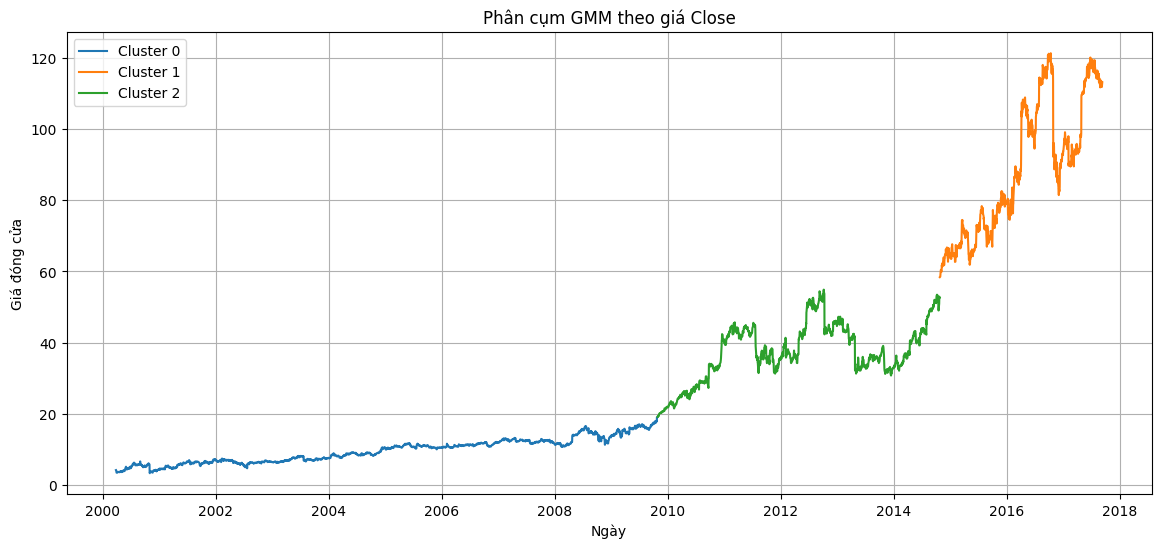

In [11]:
# Vẽ giá đóng cửa và màu theo phân cụm
plt.figure(figsize=(14, 6))

for cluster in range(n_components):
    cluster_data = df[df['GMM_Cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data['Close'], label=f'Cluster {cluster}')

plt.legend()
plt.title('Phân cụm GMM theo giá Close')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.grid(True)
plt.show()

GMM + Transformer Encoder

In [13]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv('/content/Data.csv')

df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
data = df['Close'].values.reshape(-1, 1)

# Chuẩn hóa
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(data_scaled)
gmm_labels = gmm.predict(data_scaled)  # optional: có thể làm thêm feature

# Tạo chuỗi sliding window
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(data_scaled, seq_len)

In [14]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Mô hình Transformer

In [15]:
class TransformerModel(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)  # [B, T, 1] -> [B, T, d_model]
        x = self.transformer(x)  # [B, T, d_model]
        out = self.fc(x[:, -1, :])  # lấy output cuối
        return out

Huấn luyện

In [16]:
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(seq_len=seq_len).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

writer = SummaryWriter(log_dir="logs")
# Train
epoch = 10
for epoch in range(epoch):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        writer.add_scalar('Loss/epoch', loss.item(), epoch)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")
    writer.close()

Epoch 1, Loss: 0.1361
Epoch 2, Loss: 0.0044
Epoch 3, Loss: 0.0027
Epoch 4, Loss: 0.0017
Epoch 5, Loss: 0.0014
Epoch 6, Loss: 0.0012
Epoch 7, Loss: 0.0010
Epoch 8, Loss: 0.0009
Epoch 9, Loss: 0.0010
Epoch 10, Loss: 0.0008


Dự Báo

In [17]:
# Dự báo bước tiếp theo từ chuỗi cuối cùng
model.eval()
with torch.no_grad():
    last_seq = torch.tensor(data_scaled[-seq_len:], dtype=torch.float32).unsqueeze(0).to(device)
    pred = model(last_seq).cpu().numpy()
    predicted_price = scaler.inverse_transform(pred)
    print(f"Giá dự báo tiếp theo: {predicted_price[0][0]:.4f}")

Giá dự báo tiếp theo: 121.5926


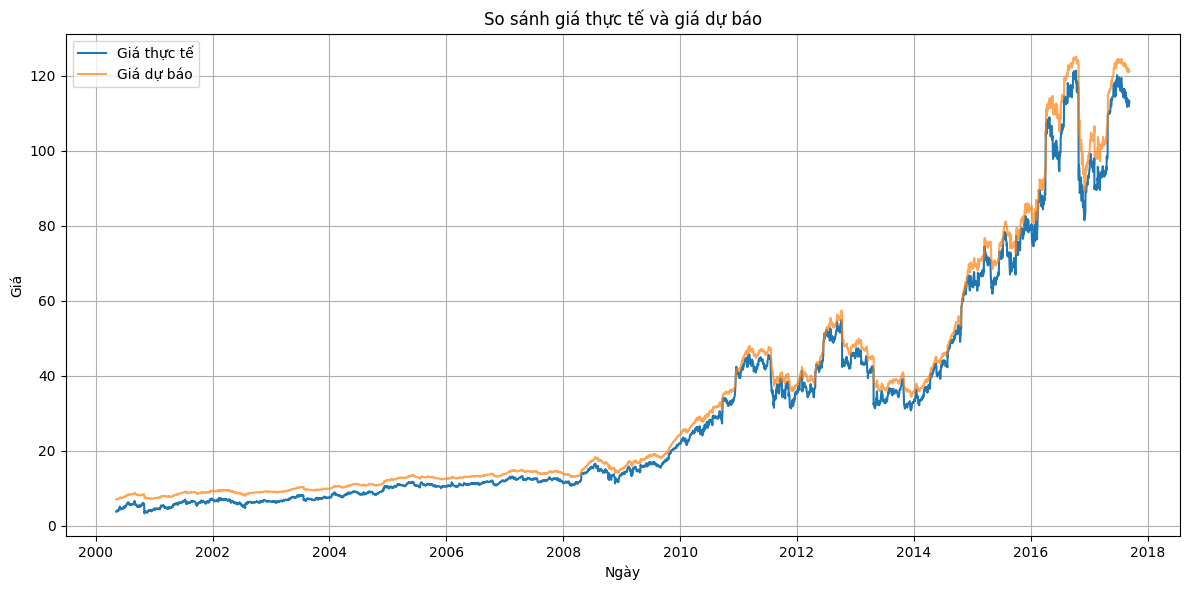

In [18]:
import matplotlib.pyplot as plt

# Dự báo toàn bộ tập dữ liệu (slide theo cửa sổ)
model.eval()
predictions = []

with torch.no_grad():
    for i in range(len(data_scaled) - seq_len):
        seq_input = torch.tensor(data_scaled[i:i+seq_len], dtype=torch.float32).unsqueeze(0).to(device)
        pred = model(seq_input)
        predictions.append(pred.cpu().numpy()[0])

# Chuyển đổi về dạng gốc
predictions = np.array(predictions)
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(data_scaled[seq_len:])  # Ground truth

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df.index[seq_len:], real_prices, label='Giá thực tế')
plt.plot(df.index[seq_len:], predicted_prices, label='Giá dự báo', alpha=0.7)
plt.title('So sánh giá thực tế và giá dự báo')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
print(df["Close"][:])

Date
2000-03-27      4.125000
2000-03-28      4.015625
2000-03-29      4.000000
2000-03-30      3.843750
2000-03-31      3.390625
                 ...    
2017-09-01    113.309998
2017-09-05    111.870003
2017-09-06    112.230003
2017-09-07    112.339996
2017-09-08    113.190002
Name: Close, Length: 4392, dtype: float64


In [21]:
print(predicted_price - 1)

[[120.59261]]
